In [403]:
from utils.dataloader import InsectsDataset, ToTensor
from utils.read import read_config
from torchvision.utils import save_image
from torch.utils.data import DataLoader
import torch
import torchvision.transforms as transforms
import torchvision
import matplotlib.pyplot as plt
import numpy as np
import PIL
import os
import pandas as pd

from tqdm.auto import tqdm
tqdm.pandas()

/opt/anaconda3/lib/python3.7/site-packages/tqdm/std.py:668: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [414]:
PIL.__version__

'7.2.0'

In [393]:
config = read_config()
base_path = os.path.join(config['base_data']['dest_dir'], 'base')
csv_file = os.path.join(base_path, 'data_info.csv')
root_dir = os.path.join(base_path, 'images')

n_data_augmentation = config['n_data_augmentation']

In [64]:
def show_img(img):
    plt.figure(figsize=(18,15))
    npimg = img.numpy()

    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [374]:
def augment_img(img, lbl, n=24, gray_scale=False):
    base_t = transforms.Compose([transforms.ToPILImage(),transforms.ToTensor()])
    img_mean = torch.mean(img.float(), dim=(1, 2))
    img = base_t(img)
                                
    transform = transforms.Compose([transforms.ToPILImage(),
                                    transforms.RandomHorizontalFlip(p=0.5),
                                    # transforms.RandomApply([transforms.RandomCrop(55)], p=0.8),
                                    transforms.Resize((64, 64)),
                                    transforms.RandomRotation(degrees=180, fill=(img_mean[0], img_mean[1], img_mean[2])),
                                    transforms.ColorJitter(brightness=0.15, contrast=0.15, saturation=0.3, hue=0.05),
                                    transforms.ToTensor()])
    
    to_gray_scale = base_t = transforms.Compose([transforms.ToPILImage(),
                                                 transforms.Grayscale(num_output_channels=3),
                                                 transforms.ToTensor()])
    
    if gray_scale is True:
            img = to_gray_scale(img)
    
    new_imgs = [img]
    lbls = [lbl]
    for i in range(n):
        new_img = transform(img)
        if gray_scale is True:
            new_img = to_gray_scale(new_img)
        new_imgs.append(new_img)
        lbls.append(lbl)
        
    # result = torch.cat(new_imgs, dim=0)
    # print(result.shape)
    return new_imgs, lbls

In [394]:
new_imgs = []
lbls = []

for class_name in n_data_augmentation:
    n = n_data_augmentation[class_name]
    print(n)
    print(class_name)
    dataset = InsectsDataset(csv_file=csv_file, root_dir=root_dir, transform=ToTensor(), class_name=class_name)
    dataloader = DataLoader(dataset=dataset, batch_size=1, shuffle=False)
    
    for i, batch in tqdm(enumerate(dataloader)):
        img = batch['image']
        lbl = batch['class_name']
        nim, lb = augment_img(img.squeeze(), lbl=lbl[0], n=n, gray_scale=False)
        new_imgs = new_imgs + nim
        lbls = lbls + lb

new_imgs = torch.stack(new_imgs, dim=0)



23
liriomyza huidobrensis



23
brevicoryne brassicae



23
prodiplosis longifila



23
trips tabaci



0
Bemisia tabaci



0
Macrolophus pygmaeus



1
Nesidiocoris tenuis


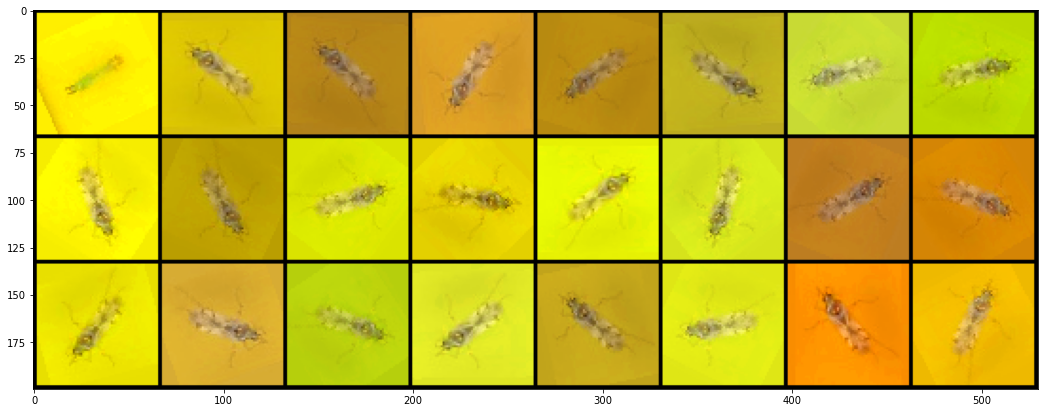

torch.Size([145, 3, 64, 64])
145


In [376]:
x=5
show_img(torchvision.utils.make_grid(new_imgs[24*x:24*(x+1)]))
print(new_imgs.shape)
print(len(lbls))

In [395]:
print(new_imgs.shape)
print(len(lbls))

torch.Size([14994, 3, 64, 64])
14994


In [398]:
filename = []
for i, lbl in enumerate(lbls):
    filename.append('img_{}.jpg'.format(i))

In [404]:
df_aug_data = pd.DataFrame.from_records({'filename': filename,'especie':lbls})
df_aug_data = df_aug_data[['filename', 'especie']]
df_aug_data

,filename,especie
0,img_0.jpg,liriomyza huidobrensis
1,img_1.jpg,liriomyza huidobrensis
2,img_2.jpg,liriomyza huidobrensis
3,img_3.jpg,liriomyza huidobrensis
4,img_4.jpg,liriomyza huidobrensis
...,...,...
14989,img_14989.jpg,Nesidiocoris tenuis
14990,img_14990.jpg,Nesidiocoris tenuis
14991,img_14991.jpg,Nesidiocoris tenuis
14992,img_14992.jpg,Nesidiocoris tenuis


In [405]:
df_aug_data['especie'].value_counts()

Bemisia tabaci            5807
liriomyza huidobrensis    2688
Macrolophus pygmaeus      1619
brevicoryne brassicae     1392
Nesidiocoris tenuis       1376
trips tabaci              1272
prodiplosis longifila      840
Name: especie, dtype: int64

In [402]:
df_aug_data

,especie,filename
0,liriomyza huidobrensis,img_0.jpg
1,liriomyza huidobrensis,img_1.jpg
2,liriomyza huidobrensis,img_2.jpg
3,liriomyza huidobrensis,img_3.jpg
4,liriomyza huidobrensis,img_4.jpg
...,...,...
14989,Nesidiocoris tenuis,img_14989.jpg
14990,Nesidiocoris tenuis,img_14990.jpg
14991,Nesidiocoris tenuis,img_14991.jpg
14992,Nesidiocoris tenuis,img_14992.jpg


In [410]:
# new_imgs
# filename
dest_dir = config['base_data']['dest_dir']
path_dest_new_imgs = 'augmented'

if not path_dest_new_imgs in os.listdir(dest_dir):
    os.mkdir(os.path.join(dest_dir, path_dest_new_imgs))
    
if not 'images' in os.listdir(os.path.join(dest_dir, path_dest_new_imgs)):
    os.mkdir(os.path.join(dest_dir, path_dest_new_imgs, 'images'))
    
for i, f in enumerate(tqdm(filename)):
    torchvision.utils.save_image(new_imgs[i], os.path.join(dest_dir, path_dest_new_imgs, 'images', f))

In [413]:
df_aug_data.to_csv(os.path.join(dest_dir, path_dest_new_imgs, 'data_info.csv'), index=False)